In [3]:
# Importing Libraries
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation


In [4]:
data = pd.read_csv("INFY20002008.csv")
data.head()

,Unnamed: 0,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
0,0,INFOSYSTCH,EQ,03-Jan-2000,14467.75,15625.00,15625.20,15625.00,15625.20,15625.20,15625.18,5137,8.026657e+07,-,-,-
1,1,INFOSYSTCH,EQ,04-Jan-2000,15625.20,16800.00,16875.25,16253.00,16875.25,16855.90,16646.38,56186,9.352937e+08,-,-,-
2,2,INFOSYSTCH,EQ,05-Jan-2000,16855.90,15701.00,16250.00,15507.45,15507.45,15507.45,15786.38,164605,2.598516e+09,-,-,-
3,3,INFOSYSTCH,EQ,06-Jan-2000,15507.45,15256.65,15300.00,14266.85,14266.85,14266.85,14462.82,81997,1.185908e+09,-,-,-
4,4,INFOSYSTCH,EQ,07-Jan-2000,14266.85,13125.50,13125.50,13125.50,13125.50,13125.50,13125.50,7589,9.960942e+07,-,-,-


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2496 entries, 0 to 2495
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              2496 non-null   int64  
 1   Symbol                  2496 non-null   object 
 2   Series                  2496 non-null   object 
 3   Date                    2496 non-null   object 
 4   Prev Close              2496 non-null   float64
 5   Open Price              2496 non-null   float64
 6   High Price              2496 non-null   float64
 7   Low Price               2496 non-null   float64
 8   Last Price              2496 non-null   float64
 9   Close Price             2496 non-null   float64
 10  Average Price           2496 non-null   float64
 11  Total Traded Quantity   2496 non-null   int64  
 12  Turnover                2496 non-null   float64
 13  No. of Trades           2496 non-null   object 
 14  Deliverable Qty         2496 non-null   

In [7]:
# we are going to use Average_price and Date for prediciton
data = data[["Date","Average Price"]]

In [8]:
# scaling the values in the range of 0 to 1
scaler=MinMaxScaler(feature_range=(0,1))
scaled_price = scaler.fit_transform(data.loc[:,'Average Price'].values.reshape(-1,1))

# Splitting the dataset into 75:25 ratio for training and test
train_size =int(data.shape[0]*0.75)
train,test = scaled_price[0:train_size,:], scaled_price[train_size:data.shape[0],:]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (1872, 624)


In [11]:
# creating dataset
def create_dataset(scaled_price, window_size=1):
    data_X, data_Y=[],[]
    for i in range(len(scaled_price)-window_size-1):
        a = scaled_price[i:(i+window_size),0]
        data_X.append(a)
        data_Y.append(scaled_price[i+window_size,0])
    return(np.array(data_X),np.array(data_Y))

In [12]:
# create training and test set for one-step-ahead regression
window_size =3
train_X,train_Y = create_dataset(train,window_size)
test_X,test_Y =create_dataset(test,window_size)
print("original training datashape")
print(train_X.shape)

# reshaping the input data into appropriate form for keras
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

original training datashape
(1868, 3)
New training data shape:
(1868, 1, 3)


In [17]:
#Designing the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape=(1,window_size)))
model.add(Dense(1))

#Compiling the model
model.compile(loss='mean_squared_error',optimizer='adam')

# trainig the model
model.fit(train_X,train_Y,epochs=3,batch_size=1)

C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0131
Epoch 2/3
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.3574e-04
Epoch 3/3
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.1619e-04


# Forecasting and visualisation

In [18]:
def predict_and_score(model,X,Y):
    
    #make predictions on the original scale of the data
    pred = scaler.inverse_transform(model.predict(X))
    
    #make Y data to be on the original scale of predicitibility
    orig_data=scaler.inverse_transform([Y])
    
    #calculate RMSE
    score = np.sqrt(mean_squared_error(orig_data[0],pred[:,0]))
    return(score,pred)

rmse_train, train_predict = predict_and_score(model,train_X,train_Y)
rmse_test, test_predict = predict_and_score(model,test_X,test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training data score: 272.99 RMSE
Test data score: 121.13 RMSE


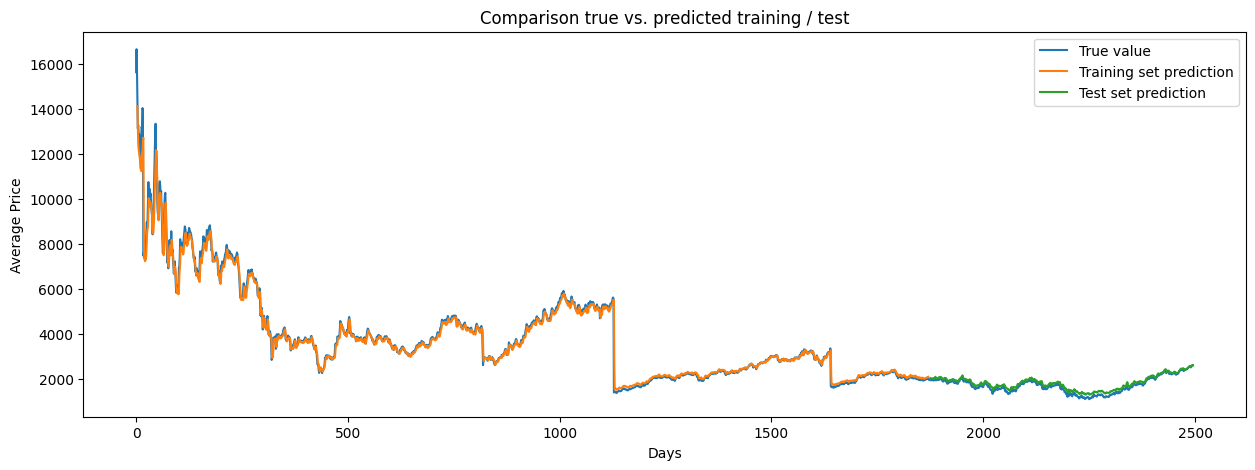

In [19]:
# Initiating with training predictions.
train_predict_plot = np.empty_like(scaled_price)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict
# Adding test predictions.
test_predict_plot = np.empty_like(scaled_price)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(scaled_price) - 1, :] = test_predict
# creating the plot
plt.figure(figsize=(15,5))
plt.plot(scaler.inverse_transform(scaled_price), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Days")
plt.ylabel("Average Price")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()